# Model Training for F&B Anomaly Detection
# Training Models with Selected Features for Optimal Performance
#
# This script trains machine learning models using the selected features from the improved feature engineering pipeline.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
from scipy import stats

In [5]:
# Import custom modules
import sys
sys.path.append('..')
from src.data_processor import DataProcessor
from src.feature_engineer import FeatureEngineer
from src.model_trainer import ModelTrainer
from src.config import MODEL_CONFIG, MODEL_DIR

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# 1. Load Engineered Features with Selected Features

In [6]:
# Load engineered features from the improved feature engineering pipeline
try:
    features_df = pd.read_csv('../data/processed/feature_engineered_data.csv')
    print("✓ Loaded pre-engineered features")
    
    # Load selected feature names from feature engineering
    selected_features_path = '../data/processed/selected_features.txt'
    if os.path.exists(selected_features_path):
        with open(selected_features_path, 'r') as f:
            selected_features = [line.strip() for line in f.readlines()]
        print(f"✓ Loaded {len(selected_features)} selected features")
        print("\nSelected features:")
        for i, feat in enumerate(selected_features[:10], 1):
            print(f"  {i:2d}. {feat}")
        if len(selected_features) > 10:
            print(f"  ... and {len(selected_features) - 10} more features")
    else:
        print("⚠ No selected features file found, will use all features")
        selected_features = None
        
except Exception as e:
    print(f"✗ Error loading features: {e}")
    print("Creating features from scratch...")
    processor = DataProcessor()
    engineer = FeatureEngineer()
    
    process_data, quality_data = processor.load_data('../data/raw/FnB_Process_Data_Batch_Wise.xlsx')
    clean_data = processor.clean_data(process_data)
    features_df = engineer.engineer_all_features(clean_data, quality_data)
    selected_features = None

print(f"\nDataset shape: {features_df.shape}")
print(f"Batches available: {len(features_df)}")

✓ Loaded pre-engineered features
✓ Loaded 58 selected features

Selected features:
   1. Yeast (kg)_mean_change_rate
   2. Oven Humidity (%)_range
   3. Water Temp (C)_max_deviation
   4. Mixer Speed (RPM)_stability
   5. Oven Humidity (%)_max_consecutive_oot
   6. Mixer Speed (RPM)_critical_deviation_ratio
   7. Sugar (kg)_min
   8. Yeast (kg)_trend_slope
   9. Water Temp (C)_range
  10. Yeast (kg)_std
  ... and 48 more features

Dataset shape: (25, 61)
Batches available: 25


# 2. Prepare Data for Training

In [7]:
# Define target columns
target_cols = ['Final_Weight', 'Quality_Score']

# Use selected features if available, otherwise use all features
if selected_features:
    # Ensure selected features exist in the dataframe
    available_features = [f for f in selected_features if f in features_df.columns]
    if available_features:
        feature_cols = available_features
        print(f"Using {len(feature_cols)} selected features from feature engineering")
    else:
        print("⚠ Selected features not found in dataframe, using all features")
        feature_cols = [col for col in features_df.columns if col not in ['Batch_ID'] + target_cols]
else:
    feature_cols = [col for col in features_df.columns if col not in ['Batch_ID'] + target_cols]
    print(f"Using all {len(feature_cols)} features")

# Prepare features and targets
X = features_df[feature_cols]
y = features_df[target_cols]

print(f"\nInitial data:")
print(f"  Features shape: {X.shape}")
print(f"  Targets shape: {y.shape}")
print(f"  Missing values in features: {X.isnull().sum().sum()}")
print(f"  Missing values in targets: {y.isnull().sum().sum()}")

Using 58 selected features from feature engineering

Initial data:
  Features shape: (25, 58)
  Targets shape: (25, 2)
  Missing values in features: 58
  Missing values in targets: 0


# 3. Data Cleaning and Outlier Removal

In [8]:
# Handle missing values
print("Handling missing values...")
X = X.fillna(X.median())  # Use median for robustness
y = y.fillna(y.median())

# Remove outliers for better model performance
print("\nRemoving outliers...")

# Method 1: IQR method for targets
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((y >= lower_bound) & (y <= upper_bound)).all(axis=1)

X_clean = X[outlier_mask]
y_clean = y[outlier_mask]

print(f"Samples before outlier removal: {len(X)}")
print(f"Samples after outlier removal: {len(X_clean)}")
print(f"Outliers removed: {len(X) - len(X_clean)}")

# Use clean data for training
X = X_clean.copy()
y = y_clean.copy()

# Display target statistics
print("\nTarget variable statistics after cleaning:")
print(y.describe())

Handling missing values...

Removing outliers...
Samples before outlier removal: 25
Samples after outlier removal: 24
Outliers removed: 1

Target variable statistics after cleaning:
       Final_Weight  Quality_Score
count     24.000000      24.000000
mean      50.227492      89.702976
std        1.491955       4.635877
min       48.059167      80.106050
25%       49.175138      86.186585
50%       49.944747      90.967498
75%       51.177332      92.650545
max       53.893148      96.710203


# 4. Train-Test Split

Training set: 19 samples
Test set: 5 samples
Features per sample: 58


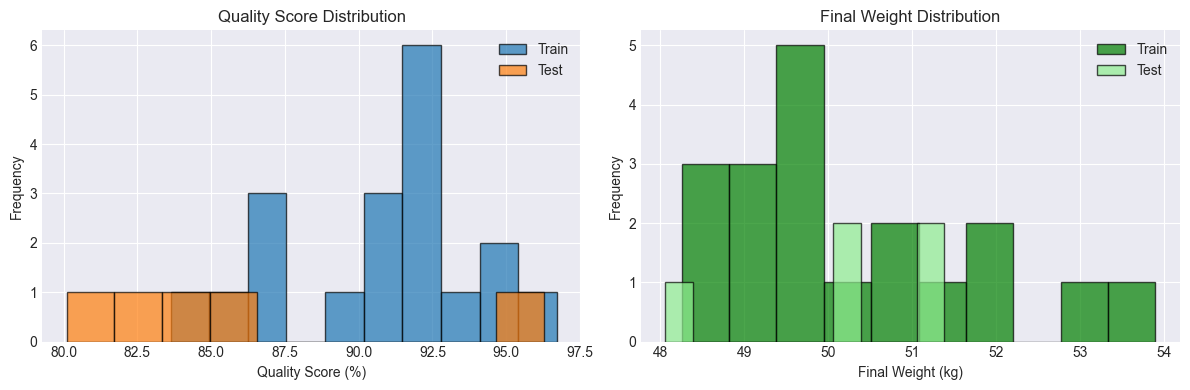

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=MODEL_CONFIG['test_size'], 
    random_state=MODEL_CONFIG['random_state']
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features per sample: {X_train.shape[1]}")

# Visualize target distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_train['Quality_Score'], bins=10, alpha=0.7, label='Train', edgecolor='black')
axes[0].hist(y_test['Quality_Score'], bins=10, alpha=0.7, label='Test', edgecolor='black')
axes[0].set_xlabel('Quality Score (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Quality Score Distribution')
axes[0].legend()

axes[1].hist(y_train['Final_Weight'], bins=10, alpha=0.7, label='Train', color='green', edgecolor='black')
axes[1].hist(y_test['Final_Weight'], bins=10, alpha=0.7, label='Test', color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Final Weight (kg)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Final Weight Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()


In [10]:
# 5. Feature Scaling

In [11]:
# Scale features for better performance
print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled to mean=0, std=1")

# Save the scaler for later use
scaler_path = '../data/models/scaler.pkl'
os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to {scaler_path}")

Scaling features...
✓ Features scaled to mean=0, std=1
✓ Scaler saved to ../data/models/scaler.pkl


# 6. Model Comparison with Cross-Validation

In [12]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

# Define models to compare
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1, max_iter=1000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42, verbosity=0)
}

# Store results
model_results = {}

# Evaluate each model using cross-validation
for model_name, base_model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Multi-output wrapper for models that need it
    if model_name in ['Ridge', 'Lasso']:
        model = MultiOutputRegressor(base_model)
    else:
        model = MultiOutputRegressor(base_model)
    
    # Cross-validation for both outputs
    try:
        # Quality score CV
        cv_scores_quality = cross_val_score(
            base_model, X_train_scaled, y_train['Quality_Score'], 
            cv=min(5, len(X_train_scaled)), scoring='r2'
        )
        
        # Weight CV
        cv_scores_weight = cross_val_score(
            base_model, X_train_scaled, y_train['Final_Weight'], 
            cv=min(5, len(X_train_scaled)), scoring='r2'
        )
        
        model_results[model_name] = {
            'quality_r2': cv_scores_quality.mean(),
            'quality_std': cv_scores_quality.std(),
            'weight_r2': cv_scores_weight.mean(),
            'weight_std': cv_scores_weight.std()
        }
        
        print(f"  Quality R²: {cv_scores_quality.mean():.4f} (±{cv_scores_quality.std()*2:.4f})")
        print(f"  Weight R²:  {cv_scores_weight.mean():.4f} (±{cv_scores_weight.std()*2:.4f})")
        
    except Exception as e:
        print(f"  Error: {str(e)}")
        model_results[model_name] = {'quality_r2': -999, 'weight_r2': -999}

# Display results summary
print("\n" + "="*60)
print("CROSS-VALIDATION SUMMARY")
print("="*60)

results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values('quality_r2', ascending=False)
print(results_df[['quality_r2', 'weight_r2']].round(4))

MODEL COMPARISON

Evaluating Ridge...
  Quality R²: -1.2687 (±5.6074)
  Weight R²:  -2.6810 (±4.0427)

Evaluating Lasso...
  Quality R²: -4.0602 (±13.4614)
  Weight R²:  -1.4086 (±3.8406)

Evaluating Random Forest...
  Quality R²: -1.5543 (±4.3035)
  Weight R²:  -1.5329 (±4.9443)

Evaluating Gradient Boosting...
  Quality R²: -1.7191 (±2.2842)
  Weight R²:  -6.6787 (±16.4182)

Evaluating XGBoost...
  Quality R²: -0.9228 (±2.3995)
  Weight R²:  -3.4128 (±6.2688)

CROSS-VALIDATION SUMMARY
                   quality_r2  weight_r2
XGBoost               -0.9228    -3.4128
Ridge                 -1.2687    -2.6810
Random Forest         -1.5543    -1.5329
Gradient Boosting     -1.7191    -6.6787
Lasso                 -4.0602    -1.4086


# 7. Select and Optimize Best Model

In [13]:
# Select best model based on quality score performance
best_model_name = results_df.index[0]
best_quality_r2 = results_df.iloc[0]['quality_r2']

print(f"Best model: {best_model_name}")
print(f"Quality R² (CV): {best_quality_r2:.4f}")

# Hyperparameter optimization for the best model
print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION")
print("="*60)

if 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [4, 6, 8, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    base_model = RandomForestRegressor(random_state=42)
elif 'XGBoost' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    base_model = xgb.XGBRegressor(random_state=42, verbosity=0)
elif 'Gradient' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [2, 5]
    }
    base_model = GradientBoostingRegressor(random_state=42)
else:
    # For Ridge/Lasso, use simpler grid
    param_grid = {}
    base_model = models[best_model_name]

# Perform grid search if parameters available
if param_grid:
    print(f"Optimizing {best_model_name}...")
    print(f"Parameter grid: {param_grid}")
    
    # Multi-output wrapper
    multi_model = MultiOutputRegressor(base_model)
    
    # Grid search (note: adjusting param names for MultiOutputRegressor)
    adjusted_param_grid = {f'estimator__{key}': value for key, value in param_grid.items()}
    
    grid_search = GridSearchCV(
        multi_model, 
        adjusted_param_grid, 
        cv=min(3, len(X_train_scaled)),  # Use fewer folds for small dataset
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
else:
    # Use default model
    best_model = MultiOutputRegressor(base_model)
    best_model.fit(X_train_scaled, y_train)
    print(f"Using {best_model_name} with default parameters")

Best model: XGBoost
Quality R² (CV): -0.9228

HYPERPARAMETER OPTIMIZATION
Optimizing XGBoost...
Parameter grid: {'n_estimators': [50, 100, 150], 'max_depth': [3, 4, 5, 6], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'subsample': [0.8, 1.0]}
Fitting 3 folds for each of 96 candidates, totalling 288 fits

Best parameters: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 3, 'estimator__n_estimators': 50, 'estimator__subsample': 0.8}
Best CV score: -0.0508


# 8. Train Final Model and Evaluate

FINAL MODEL PERFORMANCE

XGBoost Test Set Performance:

Quality Score Prediction:
  R² Score: -0.5039
  RMSE: 6.9838
  MAE: 6.3923

Final Weight Prediction:
  R² Score: 0.2481
  RMSE: 1.0166
  MAE: 0.9140


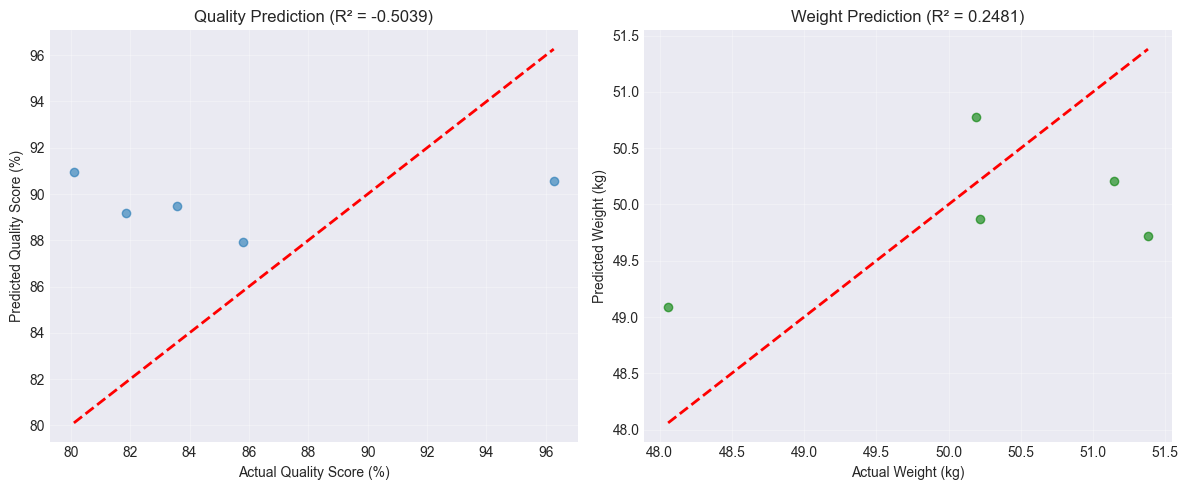

In [14]:
# Make predictions on test set
y_pred = best_model.predict(X_test_scaled)

# Calculate metrics
metrics = {
    'weight': {
        'r2': r2_score(y_test['Final_Weight'], y_pred[:, 0]),
        'mse': mean_squared_error(y_test['Final_Weight'], y_pred[:, 0]),
        'rmse': np.sqrt(mean_squared_error(y_test['Final_Weight'], y_pred[:, 0])),
        'mae': mean_absolute_error(y_test['Final_Weight'], y_pred[:, 0])
    },
    'quality': {
        'r2': r2_score(y_test['Quality_Score'], y_pred[:, 1]),
        'mse': mean_squared_error(y_test['Quality_Score'], y_pred[:, 1]),
        'rmse': np.sqrt(mean_squared_error(y_test['Quality_Score'], y_pred[:, 1])),
        'mae': mean_absolute_error(y_test['Quality_Score'], y_pred[:, 1])
    }
}

print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)

print(f"\n{best_model_name} Test Set Performance:")
print("\nQuality Score Prediction:")
print(f"  R² Score: {metrics['quality']['r2']:.4f}")
print(f"  RMSE: {metrics['quality']['rmse']:.4f}")
print(f"  MAE: {metrics['quality']['mae']:.4f}")

print("\nFinal Weight Prediction:")
print(f"  R² Score: {metrics['weight']['r2']:.4f}")
print(f"  RMSE: {metrics['weight']['rmse']:.4f}")
print(f"  MAE: {metrics['weight']['mae']:.4f}")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Quality predictions
axes[0].scatter(y_test['Quality_Score'], y_pred[:, 1], alpha=0.6)
axes[0].plot([y_test['Quality_Score'].min(), y_test['Quality_Score'].max()],
            [y_test['Quality_Score'].min(), y_test['Quality_Score'].max()],
            'r--', lw=2)
axes[0].set_xlabel('Actual Quality Score (%)')
axes[0].set_ylabel('Predicted Quality Score (%)')
axes[0].set_title(f'Quality Prediction (R² = {metrics["quality"]["r2"]:.4f})')
axes[0].grid(True, alpha=0.3)

# Weight predictions
axes[1].scatter(y_test['Final_Weight'], y_pred[:, 0], alpha=0.6, color='green')
axes[1].plot([y_test['Final_Weight'].min(), y_test['Final_Weight'].max()],
            [y_test['Final_Weight'].min(), y_test['Final_Weight'].max()],
            'r--', lw=2)
axes[1].set_xlabel('Actual Weight (kg)')
axes[1].set_ylabel('Predicted Weight (kg)')
axes[1].set_title(f'Weight Prediction (R² = {metrics["weight"]["r2"]:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. Train Anomaly Detection Model

ANOMALY DETECTION MODEL

Training Isolation Forest with contamination=0.1

Anomaly Detection Results:
  Training samples: 19
  Test samples: 5
  Anomalies detected: 2 (40.0%)
  Normal samples: 3 (60.0%)


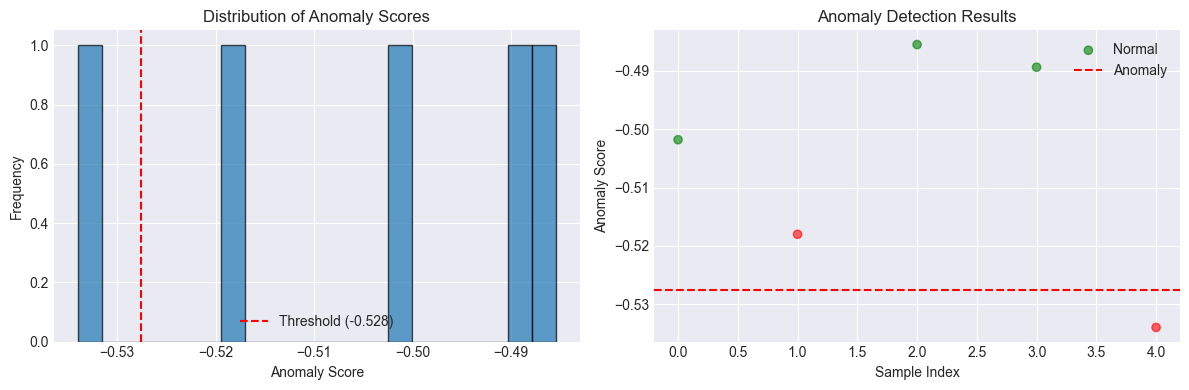

In [15]:
print("="*60)
print("ANOMALY DETECTION MODEL")
print("="*60)

# Train Isolation Forest for anomaly detection
contamination = MODEL_CONFIG.get('contamination', 0.1)
print(f"\nTraining Isolation Forest with contamination={contamination}")

anomaly_detector = IsolationForest(
    contamination=contamination,
    random_state=MODEL_CONFIG['random_state'],
    n_jobs=-1
)

# Fit on training data
anomaly_detector.fit(X_train_scaled)

# Predict anomalies in test set
anomaly_predictions = anomaly_detector.predict(X_test_scaled)
anomaly_scores = anomaly_detector.score_samples(X_test_scaled)

# Count anomalies
n_anomalies = (anomaly_predictions == -1).sum()
anomaly_rate = n_anomalies / len(anomaly_predictions) * 100

print(f"\nAnomaly Detection Results:")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Test samples: {len(X_test_scaled)}")
print(f"  Anomalies detected: {n_anomalies} ({anomaly_rate:.1f}%)")
print(f"  Normal samples: {len(anomaly_predictions) - n_anomalies} ({100-anomaly_rate:.1f}%)")

# Visualize anomaly scores
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(anomaly_scores, bins=20, edgecolor='black', alpha=0.7)
threshold = np.percentile(anomaly_scores, contamination * 100)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.3f})')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()

plt.subplot(1, 2, 2)
colors = ['green' if x == 1 else 'red' for x in anomaly_predictions]
plt.scatter(range(len(anomaly_predictions)), anomaly_scores, c=colors, alpha=0.6)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection Results')
plt.legend(['Normal', 'Anomaly', 'Threshold'])

plt.tight_layout()
plt.show()

# 10. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
   1. Oven Humidity (%)_deviation_std         : 0.1540
   2. Water Temp (C)_range                    : 0.1499
   3. Water Temp (C)_time_to_steady           : 0.1142
   4. Mixer Speed (RPM)_trend_strength        : 0.0847
   5. Yeast (kg)_mean_deviation               : 0.0686
   6. Water Temp (C)_median                   : 0.0653
   7. Yeast (kg)_kurtosis                     : 0.0509
   8. Yeast (kg)_trend_slope                  : 0.0434
   9. Yeast (kg)_max_consecutive_oot          : 0.0356
  10. Salt (kg)_mean_change_rate              : 0.0352
  11. Oven Humidity (%)_median                : 0.0257
  12. Mixing Temp (C)_mean                    : 0.0235
  13. Mixer Speed (RPM)_stability             : 0.0216
  14. Water Temp (C)_max_deviation            : 0.0173
  15. Flour (kg)_range                        : 0.0153


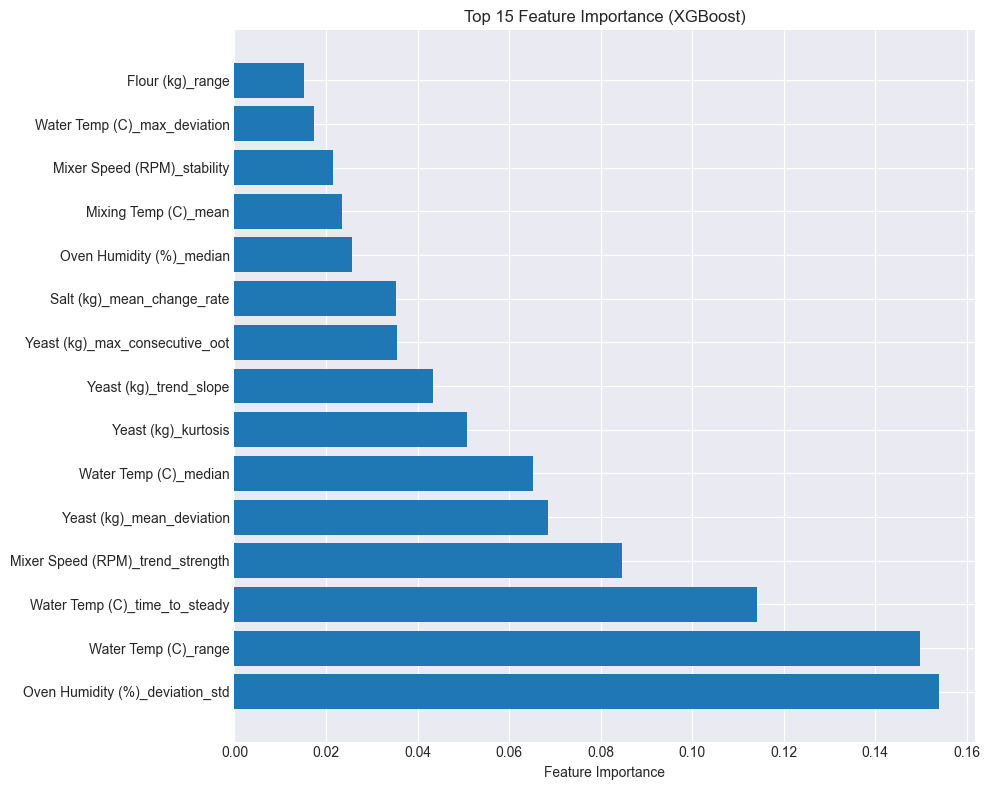

In [16]:
# Extract feature importance if available
if hasattr(best_model, 'estimators_'):
    # Get feature importance from each estimator
    importances = []
    
    for estimator in best_model.estimators_:
        if hasattr(estimator, 'feature_importances_'):
            importances.append(estimator.feature_importances_)
    
    if importances:
        # Average importance across outputs
        avg_importance = np.mean(importances, axis=0)
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)
        
        print("="*60)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*60)
        
        print("\nTop 15 Most Important Features:")
        for i, row in enumerate(importance_df.head(15).itertuples(), 1):
            print(f"  {i:2d}. {row.Feature:40s}: {row.Importance:.4f}")
        
        # Visualize feature importance
        plt.figure(figsize=(10, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['Importance'])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importance ({best_model_name})')
        plt.tight_layout()
        plt.show()
else:
    print("Feature importance not available for this model type")
    importance_df = None

# 11. Save Models and Artifacts

In [17]:
print("="*60)
print("SAVING MODELS AND ARTIFACTS")
print("="*60)

# Create models directory
models_dir = '../data/models'
os.makedirs(models_dir, exist_ok=True)

# Generate timestamp for versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the main quality prediction model
model_path = f'{models_dir}/quality_model_{timestamp}.pkl'
joblib.dump(best_model, model_path)
print(f"✓ Quality model saved to: {model_path}")

# Save the anomaly detector
anomaly_path = f'{models_dir}/anomaly_detector_{timestamp}.pkl'
joblib.dump(anomaly_detector, anomaly_path)
print(f"✓ Anomaly detector saved to: {anomaly_path}")

# Save the scaler (already saved earlier, but save with timestamp too)
scaler_path_ts = f'{models_dir}/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_path_ts)
print(f"✓ Scaler saved to: {scaler_path_ts}")

# Save model metadata
metadata = {
    'timestamp': timestamp,
    'model_type': best_model_name,
    'n_features': len(feature_cols),
    'selected_features': selected_features if selected_features else feature_cols,
    'n_training_samples': len(X_train),
    'n_test_samples': len(X_test),
    'metrics': metrics,
    'contamination': contamination,
    'anomaly_rate_test': anomaly_rate
}

# Save best parameters if grid search was performed
if 'grid_search' in locals() and hasattr(grid_search, 'best_params_'):
    metadata['best_params'] = grid_search.best_params_

metadata_path = f'{models_dir}/model_metadata_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✓ Model metadata saved to: {metadata_path}")

# Save feature importance if available
if importance_df is not None:
    importance_path = f'{models_dir}/feature_importance_{timestamp}.csv'
    importance_df.to_csv(importance_path, index=False)
    print(f"✓ Feature importance saved to: {importance_path}")

print("\nAll models and artifacts saved successfully!")

SAVING MODELS AND ARTIFACTS
✓ Quality model saved to: ../data/models/quality_model_20250823_212703.pkl
✓ Anomaly detector saved to: ../data/models/anomaly_detector_20250823_212703.pkl
✓ Scaler saved to: ../data/models/scaler_20250823_212703.pkl
✓ Model metadata saved to: ../data/models/model_metadata_20250823_212703.json
✓ Feature importance saved to: ../data/models/feature_importance_20250823_212703.csv

All models and artifacts saved successfully!


# 12. Final Summary

In [18]:
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset:")
print(f"  Total samples: {len(features_df)}")
print(f"  After cleaning: {len(X)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Features used: {len(feature_cols)}")
if selected_features:
    print(f"  Using selected features from feature engineering")

print(f"\n🏆 Best Model: {best_model_name}")
if 'grid_search' in locals() and hasattr(grid_search, 'best_params_'):
    print(f"  Optimized parameters: {grid_search.best_params_}")

print(f"\n📈 Performance Metrics:")
print(f"  Quality Score Prediction:")
print(f"    R² Score: {metrics['quality']['r2']:.4f}")
print(f"    MAE: {metrics['quality']['mae']:.2f}%")
print(f"  Final Weight Prediction:")
print(f"    R² Score: {metrics['weight']['r2']:.4f}")
print(f"    MAE: {metrics['weight']['mae']:.2f} kg")

print(f"\n🔍 Anomaly Detection:")
print(f"  Contamination rate: {contamination:.1%}")
print(f"  Test set anomalies: {anomaly_rate:.1f}%")

print(f"\n💾 Saved Artifacts:")
print(f"  Model: {model_path}")
print(f"  Anomaly Detector: {anomaly_path}")
print(f"  Scaler: {scaler_path_ts}")
print(f"  Metadata: {metadata_path}")

# Performance interpretation
print(f"\n💡 Performance Interpretation:")
if metrics['quality']['r2'] > 0.5:
    print("  ✅ Good predictive performance for quality score")
elif metrics['quality']['r2'] > 0.2:
    print("  ⚠️  Moderate predictive performance for quality score")
else:
    print("  ❌ Low predictive performance for quality score")

if metrics['weight']['r2'] > 0.5:
    print("  ✅ Good predictive performance for weight")
elif metrics['weight']['r2'] > 0.2:
    print("  ⚠️  Moderate predictive performance for weight")
else:
    print("  ❌ Low predictive performance for weight")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

MODEL TRAINING SUMMARY

📊 Dataset:
  Total samples: 25
  After cleaning: 24
  Training samples: 19
  Test samples: 5
  Features used: 58
  Using selected features from feature engineering

🏆 Best Model: XGBoost
  Optimized parameters: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 3, 'estimator__n_estimators': 50, 'estimator__subsample': 0.8}

📈 Performance Metrics:
  Quality Score Prediction:
    R² Score: -0.5039
    MAE: 6.39%
  Final Weight Prediction:
    R² Score: 0.2481
    MAE: 0.91 kg

🔍 Anomaly Detection:
  Contamination rate: 10.0%
  Test set anomalies: 40.0%

💾 Saved Artifacts:
  Model: ../data/models/quality_model_20250823_212703.pkl
  Anomaly Detector: ../data/models/anomaly_detector_20250823_212703.pkl
  Scaler: ../data/models/scaler_20250823_212703.pkl
  Metadata: ../data/models/model_metadata_20250823_212703.json

💡 Performance Interpretation:
  ❌ Low predictive performance for quality score
  ⚠️  Moderate predictive performance for weight

TRAINING COMPLETE